# Galaxy Tool Sequence Prediction - Improved Training

In [1]:
import os, time, json, sys, logging
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Set project root
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("lstm_training")
logger.info(f"Project Root: {PROJECT_ROOT}")

2026-02-13 22:13:50,876 - INFO - Project Root: /home/henok/Desktop/Galaxy-GNN-XP-2


In [ ]:
# 1. Hyperparameter Configuration
config = {
    "batch_size": 64,
    "epochs": 50,
    "lr": 1e-3,
    "embed_dim": 128,
    "hidden_dim": 256,
    "num_layers": 2,
    "dropout": 0.3,
    "weight_decay": 1e-4,
    "patience": 7,
    "grad_clip": 1.0,
    "label_smoothing": 0.1
}

In [3]:
# 2. Load Processed Data
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_SAVE_DIR = PROJECT_ROOT / "Outputs"
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

logger.info("Loading datasets...")
X_train = torch.load(PROCESSED_DATA_DIR / "X_train.pt")
y_train = torch.load(PROCESSED_DATA_DIR / "y_train.pt")
X_test = torch.load(PROCESSED_DATA_DIR / "X_test.pt")
y_test = torch.load(PROCESSED_DATA_DIR / "y_test.pt")

with open(PROCESSED_DATA_DIR / "vocab.json", "r") as f:
    v_dict = json.load(f)
    stoi, itos = v_dict["stoi"], {int(k): v for k, v in v_dict["itos"].items()}

vocab_size, pad_idx = len(stoi), stoi.get("<PAD>", 0)
logger.info(f"Vocab Size: {vocab_size} | Training Samples: {len(X_train)} | Test Samples: {len(X_test)}")

2026-02-13 22:15:23,969 - INFO - Loading datasets...
2026-02-13 22:15:24,285 - INFO - Vocab Size: 1522 | Training Samples: 7804 | Test Samples: 1083


In [4]:
# 3. Model Architecture
class GalaxyPredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        # Use dropout in LSTM if num_layers > 1
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0, 
                            bidirectional=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        # x shape: (batch, seq, embed_dim)
        out, _ = self.lstm(x)
        # Take the last time step output
        out = self.drop(out[:, -1, :])
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GalaxyPredictor(
    vocab_size, 
    embed_dim=config["embed_dim"], 
    hidden_dim=config["hidden_dim"], 
    num_layers=config["num_layers"], 
    dropout=config["dropout"]
).to(device)
logger.info(f"Model initialized on device: {device}")

2026-02-13 22:15:32,460 - INFO - Model initialized on device: cpu


In [6]:
# 4. Enhanced Training Loop
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=config["batch_size"], shuffle=False)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=config["label_smoothing"])
optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
patience_counter = 0
train_hist, val_hist = [], []
timestamp = time.strftime("%Y%m%d_%H%M%S")
best_model_path = MODEL_SAVE_DIR / f"best_galaxy_lstm_{timestamp}.pth"

logger.info("Starting improved training loop...")
for epoch in range(config["epochs"]):
    # --- Training Phase ---
    model.train()
    epoch_train_loss = 0
    for bx, by in train_loader:
        bx, by = bx.to(device), by.to(device)
        optimizer.zero_grad()
        outputs = model(bx)
        loss = criterion(outputs, by)
        loss.backward()
        if config["grad_clip"] > 0:
            nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    
    # --- Validation Phase ---
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)
            outputs = model(bx)
            loss = criterion(outputs, by)
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    
    train_hist.append(avg_train_loss)
    val_hist.append(avg_val_loss)
    
    # Scheduler update
    scheduler.step(avg_val_loss)
    
    curr_lr = optimizer.param_groups[0]['lr']
    logger.info(f"Epoch {epoch+1:02d}/{config['epochs']} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {curr_lr:.6f}")
    
    # --- Early Stopping & Checkpointing ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        logger.info(f"  --> Best model saved with val_loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= config["patience"]:
            logger.warning(f"Early stopping triggered at epoch {epoch+1}")
            break

logger.info(f"Training complete. Best val_loss: {best_val_loss:.4f}")
logger.info(f"Final model saved to {best_model_path.name}")

2026-02-13 22:16:06,401 - INFO - Starting improved training loop...
2026-02-13 22:16:23,684 - INFO - Epoch 01/50 | Train Loss: 5.8800 | Val Loss: 5.6232 | LR: 0.001000
2026-02-13 22:16:23,699 - INFO -   --> Best model saved with val_loss: 5.6232
2026-02-13 22:16:36,760 - INFO - Epoch 02/50 | Train Loss: 4.8527 | Val Loss: 5.2763 | LR: 0.001000
2026-02-13 22:16:36,922 - INFO -   --> Best model saved with val_loss: 5.2763
2026-02-13 22:16:56,106 - INFO - Epoch 03/50 | Train Loss: 4.1977 | Val Loss: 5.0305 | LR: 0.001000
2026-02-13 22:16:56,266 - INFO -   --> Best model saved with val_loss: 5.0305
2026-02-13 22:17:07,625 - INFO - Epoch 04/50 | Train Loss: 3.6891 | Val Loss: 4.8913 | LR: 0.001000
2026-02-13 22:17:08,077 - INFO -   --> Best model saved with val_loss: 4.8913
2026-02-13 22:17:20,639 - INFO - Epoch 05/50 | Train Loss: 3.2819 | Val Loss: 4.8082 | LR: 0.001000
2026-02-13 22:17:20,793 - INFO -   --> Best model saved with val_loss: 4.8082
2026-02-13 22:17:33,734 - INFO - Epoch 06/

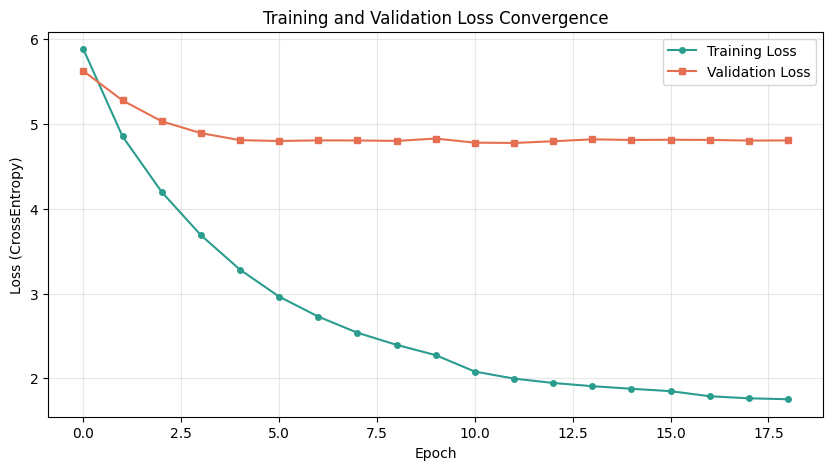

In [7]:
# 5. Training Visualization
plt.figure(figsize=(10, 5))
plt.plot(train_hist, label='Training Loss', color='#2A9D8F', marker='o', markersize=4)
plt.plot(val_hist, label='Validation Loss', color='#E76F51', marker='s', markersize=4)
plt.title('Training and Validation Loss Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss (CrossEntropy)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [8]:
# 6. Tool Recommendation Demo
def recommend(context, k=5, context_len=5):
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    unk = stoi.get("<UNK>", pad_idx)
    ids = [stoi.get(str(t), unk) for t in context][-context_len:]
    ids = [pad_idx]*(context_len - len(ids)) + ids
    inp = torch.tensor([ids], dtype=torch.long).to(device)
    with torch.no_grad():
        p = torch.softmax(model(inp), dim=1)
        vals, idxs = torch.topk(p, k=k)
    return [(itos[i.item()], v.item()) for v, i in zip(vals[0], idxs[0])]

print("\n--- INTERACTIVE RECOMMENDATION DEMO ---")
# Sample context from first test sequence if possible
demo_ctx = ['fastq_stats_tool', 'bwa_mem'] # Example
if 'bwa_mem' not in stoi:
    # Fallback to whatever is in vocab
    for i in range(10, 100):
        if itos[i] not in ['<PAD>', '<UNK>']:
            demo_ctx = [itos[i-1], itos[i]]; break

print(f"Context: {demo_ctx}")
results = recommend(demo_ctx)
print("Predicted next tools:")
for tool, prob in results:
    print(f"  {tool}: {prob:.3f}")


--- INTERACTIVE RECOMMENDATION DEMO ---
Context: ['Align.seqs', 'Filter.seqs']
Predicted next tools:
  StringTie: 0.036
  Scanpy FindVariableGenes: 0.020
  Pre.cluster: 0.018
  StringTie merge: 0.011
  Unzip: 0.011
